In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import os; print(os.getcwd())

import result_utils

/net/lem/data1/regt/retrieval_base/Luhman_16/figures


In [2]:
name_A = 'Luhman 16A'; name_B = 'Luhman 16B'
color_A = '#FF622E'; color_B = '#396ED8'

lw_d = 0.8
lw_m = 1.0

res_alpha = 0.85

A = result_utils.RetrievalResults('../retrieval_outputs/J_A_ret_21_1column_n1000/test_')
B = result_utils.RetrievalResults('../retrieval_outputs/J_B_ret_57_1column_n1000/test_')

../retrieval_outputs/J_A_ret_21_1column_n1000/test_data
  analysing data from ../retrieval_outputs/J_A_ret_21_1column_n1000/test_.txt
../retrieval_outputs/J_B_ret_57_1column_n1000/test_data
  analysing data from ../retrieval_outputs/J_B_ret_57_1column_n1000/test_.txt


In [3]:
scale = 1e-13

import copy
def get_CCF(Res, line_species_CCF):

    Res.load_components(['Chem'])
    m_set = Res.model_settings[0]
    all_line_species = np.array(Res.Chem[m_set].line_species)

    # Model w/o species X
    Res.get_model_spectrum(line_species_to_exclude=[line_species_CCF])
    m_spec_to_subtract = copy.deepcopy(Res.m_spec_broad)

    # Model w/o all other species
    line_species_to_exclude = all_line_species[all_line_species != line_species_CCF]
    Res.get_model_spectrum(line_species_to_exclude=line_species_to_exclude)
    m_spec_template = copy.deepcopy(Res.m_spec_broad)

    kwargs = dict(filter_type='savgol', window_length=301, polyorder=2, mode='interp')
    rv, CCF = Res.get_CCF(
        m_spec_template=m_spec_template, 
        m_spec_to_subtract=m_spec_to_subtract, 
        high_pass_filter={
            'm_res': result_utils.HighPassFilter(**kwargs), # Filter on model
            'd_res': result_utils.HighPassFilter(**kwargs), # Filter on data
            },
        )
    CCF_SNR = result_utils.convert_CCF_to_SNR(rv, CCF.sum(axis=-1), rv_sep=100)

    # Get the complete model spectrum
    Res.get_model_spectrum()
    m_spec_complete = copy.deepcopy(Res.m_spec_broad)

    return m_set, m_spec_complete, m_spec_to_subtract, m_spec_template, rv, CCF, CCF_SNR


def indicate_ghost(
        ax, v_bary, show_text=True, va='bottom', 
        cmap=mpl.colors.LinearSegmentedColormap.from_list('',['0.9','1.0'])
        ):
    
    ghosts = np.array([
        [1119.44,1120.33], [1142.78,1143.76], [1167.12,1168.08], 
        [1192.52,1193.49], [1219.01,1220.04], [1246.71,1247.76], 
        [1275.70,1276.80], [1306.05,1307.15], [1337.98,1338.94], 
    ])
    ghosts += np.array([-0.1,+0.1])
    ghosts *= (1+v_bary/3e5)

    ylim = ax.get_ylim()
    height = np.abs(np.diff(ylim))
    for ghost_i in ghosts:
        # Plot the masked wavelengths due to the ghost signature        
        Z = np.abs(np.linspace(*ghost_i, 20) - ghost_i.mean())
        ax.imshow(
            Z.reshape(-1,1).T, cmap=cmap, vmin=0, vmax=Z.max(), 
            extent=[*ghost_i, *ylim], interpolation='bilinear', 
            aspect='auto', zorder=-1
            )
        if not show_text:
            continue

        # Add a label
        xy = (ghost_i.mean(),ylim[0]+0.07*height)
        if va == 'top':
            xy = (ghost_i.mean(),ylim[1]-0.07*height)
        ax.annotate(
            'ghost', xy=xy, rotation=90, ha='center', va=va, fontsize=9, color='0.4'
        )
        
def plot_detection_analysis(name, species, Res, m_set, m_spec_complete, m_spec_to_subtract, c_species, c_d, c_m, xlims, res_ylim, **kwargs):

    # Required for plot
    Res.load_components(['d_spec', 'LogLike'])

    fig = plt.figure(figsize=(9,3.0))
    gs = fig.add_gridspec(
        nrows=2, ncols=3, hspace=0.24, wspace=0.04, 
        width_ratios=[0.36,0.36,0.28], height_ratios=[0.2,0.8], 
    )
    ax = np.array([fig.add_subplot(gs[-1,0]), fig.add_subplot(gs[-1,1])])
    ax_res = fig.add_subplot(gs[0,:2])

    for i, xlim_i in enumerate(xlims):

        for j in range(Res.d_spec[m_set].n_chips):
            wave_j = Res.d_spec[m_set].wave[j]
            d_flux_j = Res.d_spec[m_set].flux[j]

            mask = np.ones_like(d_flux_j)
            #mask[np.isnan(d_flux_j)] = np.nan
            mask[[0,-1]] = np.nan

            m_flux_j = m_spec_complete[m_set].flux_binned[j] * Res.LogLike.phi[j] * mask
            m_flux_wo_species_j = m_spec_to_subtract[m_set].flux_binned[j] * Res.LogLike.phi[j] * mask

            ax_res.plot(wave_j, m_flux_j-m_flux_wo_species_j, color=c_species, lw=lw_m)

            # Outside of plot range
            if (wave_j < xlim_i[0]).all():
                continue
            if (wave_j > xlim_i[1]).all():
                continue
            
            ax[i].plot(wave_j, d_flux_j/scale, color=c_d, lw=lw_d, zorder=-1)
            
            ax[i].fill_between(
                wave_j, m_flux_j/scale, m_flux_wo_species_j/scale, color=c_species, lw=0, alpha=res_alpha
                )
            ax[i].plot(wave_j, m_flux_wo_species_j/scale, color=c_species, lw=lw_m)
            ax[i].plot(wave_j, m_flux_j/scale, color=c_m, lw=lw_m)

        ylim_i = kwargs.get('ylims',[ax[i].get_ylim()]*len(xlims))[i]
        ax[i].set(xlim=xlim_i, ylim=ylim_i)

    ax_res.ticklabel_format(axis='y', style='sci', scilimits=(-13,-13))
    ax_res.set(
        xlim=(Res.d_spec[m_set].wave.min()-5,Res.d_spec[m_set].wave.max()+5), 
        ylim=res_ylim, ylabel=r'$\mathrm{Res.}$'
        )

    for ax_i in ax:
        # Indicate the location of the zoom-ins
        x0 = ax_i.get_xlim()[0]
        width  = np.abs(ax_i.get_xlim()[1] - x0)

        # Plot the inset rectangle(s)
        x0 = ax_i.get_xlim()[0]
        y0 = ax_res.get_ylim()[0]
        width  = np.abs(ax_i.get_xlim()[1] - x0)
        height = np.abs(ax_i.get_ylim()[1] - y0)
        bounds = (x0, y0, width, 0)

        _, con_patch = ax_res.indicate_inset(
            bounds=bounds, inset_ax=ax_i, edgecolor='k', lw=2, alpha=1, clip_on=False, 
            )
        for con_patch_j in con_patch:
            if con_patch_j.xy1[1]==0:
                con_patch_j.set_visible(False)
                continue

            con_patch_j.set_visible(True)
            con_patch_j.set_linewidth(0.8)
            con_patch_j.set_alpha(0.2)

        # Plot the masked wavelengths due to the ghost signature
        indicate_ghost(
            ax_i, v_bary=Res.d_spec[m_set].v_bary, show_text=False, 
            cmap=mpl.colors.LinearSegmentedColormap.from_list('',['0.9','1.0'])
            )

    ylim = np.asarray([ax_i.get_ylim() for ax_i in ax])
    for ax_i in ax:
        ax_i.set(ylim=(ylim[:,0].min(), ylim[:,1].max()))

    ax[0].set(
        ylabel=r'$F_\lambda\ \mathrm{(erg\ s^{-1}\ cm^{-2}\ nm^{-1})}$'
        )
    ax[0].set_xlabel(r'Wavelength (nm)', x=1)
    ax[1].set(yticks=[])

    plt.subplots_adjust(left=0.09, bottom=0.16, top=0.92, right=0.93)

    _, y1, *_ = ax[1].get_position().extents
    *_, x2, y2 = ax_res.get_position().extents

    ax_CCF = fig.add_axes(rect=(x2+0.025,y1+0.12,0.93-(x2+0.025),y2-y1-2*0.12))
    ax_CCF.plot(rv, CCF_SNR, c=c_species, lw=1.3)

    ax_CCF.set(
        ylabel='CCF S/N', xlim=(-400,400), ylim=kwargs.get('CCF_ylim',None), 
        xlabel=r'$v_\mathrm{rad}\ \mathrm{(km\ s^{-1})}$', 
        )
    ax_CCF.yaxis.set_label_position('right')
    ax_CCF.yaxis.tick_right()

    # S/N label
    SNR_rv0 = CCF_SNR[rv==0.][0]
    arrowprops = {
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=70,angleB=0', 
        'shrinkA':0, 'shrinkB':5, 'lw':1, 'color':c_species, 'alpha':0.8, 
    }
    ax_CCF.annotate(
        'S/N={:.1f}'.format(SNR_rv0), xy=(0,SNR_rv0*0.85), xytext=(-200,SNR_rv0*0.63), 
        color=c_species, ha='center', va='top', fontsize=10, fontweight='bold', arrowprops=arrowprops, 
        )

    # Add the species label
    ax_CCF.annotate(
        species, xy=(0.5,1.05), color=c_species, ha='center', va='bottom', 
        fontsize=14, fontweight='bold', xycoords=ax_CCF.transAxes
        )
    
    # Add the name label
    ax[1].annotate(
        name, xy=(0.97,0.04), xycoords='axes fraction', ha='right', va='bottom', c=c_m, fontsize=13, 
        fontweight='bold', path_effects=[pe.withStroke(linewidth=2, foreground='w', alpha=0.8)]
        )

    plt.savefig(f'./plots/J_band_CCF_{name}_{species}.pdf')
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [01:01<00:00, 32.34it/s]


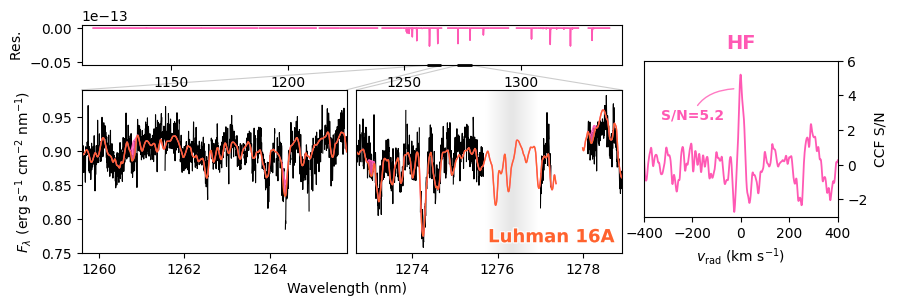

In [4]:
width = 6.2
xlims = [(wave_cen-width/2, wave_cen+width/2) for wave_cen in [1262.7, 1275.8]]

m_set, m_spec_complete, m_spec_to_subtract, _, rv, CCF, CCF_SNR = get_CCF(A, '1H-19F__Coxon-Hajig')
plot_detection_analysis(
    'Luhman 16A', 'HF', A, m_set, m_spec_complete, m_spec_to_subtract, 
    c_species='#FF59B4', c_d='k', c_m=color_A, xlims=xlims, ylims=[(0.75,0.99)]*2, 
    res_ylim=(-5.5e-15,0.5e-15), CCF_ylim=(-3,6), 
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [01:12<00:00, 27.57it/s]


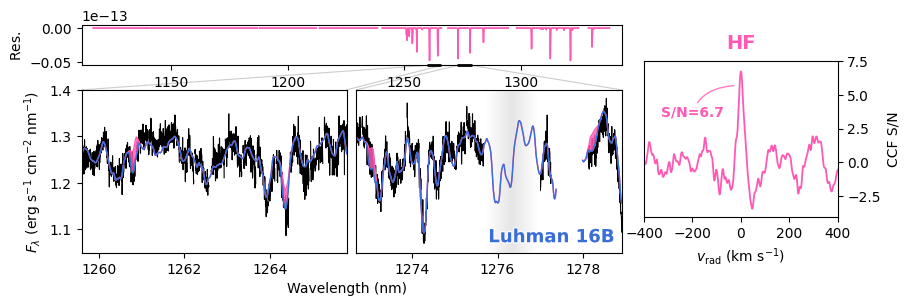

In [5]:
width = 6.2
xlims = [(wave_cen-width/2, wave_cen+width/2) for wave_cen in [1262.7, 1275.8]]

m_set, m_spec_complete, m_spec_to_subtract, _, rv, CCF, CCF_SNR = get_CCF(B, '1H-19F__Coxon-Hajig')
plot_detection_analysis(
    'Luhman 16B', 'HF', B, m_set, m_spec_complete, m_spec_to_subtract, 
    c_species='#FF59B4', c_d='k', c_m=color_B, xlims=xlims, ylims=[(1.05,1.4)]*2, 
    res_ylim=(-5.5e-15,0.5e-15), CCF_ylim=(-4,7.5), 
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [01:31<00:00, 21.80it/s]


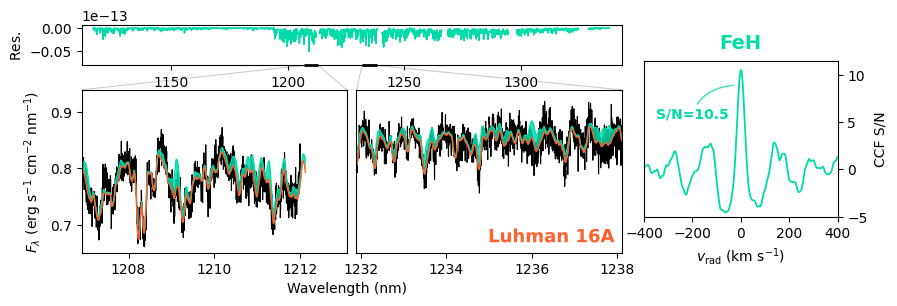

In [6]:
width = 6.2
xlims = [(wave_cen-width/2, wave_cen+width/2) for wave_cen in [1210.0, 1235.0]]

m_set, m_spec_complete, m_spec_to_subtract, _, rv, CCF, CCF_SNR = get_CCF(A, '56Fe-1H__MoLLIST')
plot_detection_analysis(
    'Luhman 16A', 'FeH', A, m_set, m_spec_complete, m_spec_to_subtract, 
    c_species='#00DBA8', c_d='k', c_m=color_A, xlims=xlims, ylims=[(0.65,0.94)]*2, 
    res_ylim=(-8e-15,0.7e-15), CCF_ylim=(-5,11.5), 
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2001/2001 [01:30<00:00, 22.16it/s]


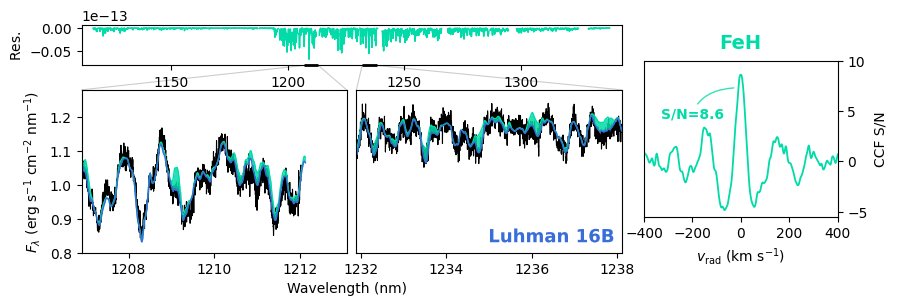

In [7]:
width = 6.2
xlims = [(wave_cen-width/2, wave_cen+width/2) for wave_cen in [1210.0, 1235.0]]

m_set, m_spec_complete, m_spec_to_subtract, _, rv, CCF, CCF_SNR = get_CCF(B, '56Fe-1H__MoLLIST')
plot_detection_analysis(
    'Luhman 16B', 'FeH', B, m_set, m_spec_complete, m_spec_to_subtract, 
    c_species='#00DBA8', c_d='k', c_m=color_B, xlims=xlims, ylims=[(0.8,1.28)]*2, 
    res_ylim=(-8e-15,0.7e-15), CCF_ylim=(-5.5,10), 
    )